# Dynamic optimization of human walking speeds

## Optimization of energy and time predicts dynamic speeds for human walking

Take walks of varying distances, and show how the optimal trajectory has
an inverted-U velocity profile, with peak speed that increases with
distance up to about 12 steps. The cost function is net mechanical work,
plus a linear cost of time with coefficient ctime.

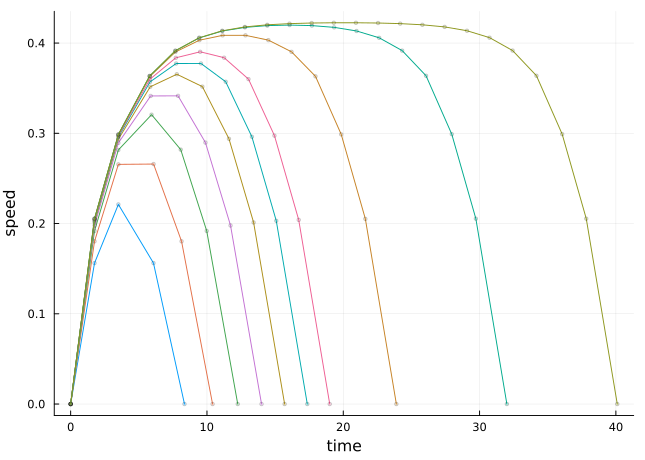

In [1]:
using DynLoco, Plots; #plotlyjs()

wstar4 = findgait(WalkRW2l(α=0.35,safety=true), target=:speed=>0.3, varying=:P)
ctime = 0.015 # cost of time, to encourage hurrying
tchange = 1.75 # boundary condition time to get up to speed (arbitrary, excluded from optimization) 
p = plot() 
walksteps = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
for (i,nsteps) in enumerate(walksteps)
    result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=tchange, usespline=false, color=i, speedtype=:shortwalks, rampuporder=1, markersize=2) # plot instantaneous body speed vs. time
    push!(results, result) # add this optimization to results array
end
Plots.display(p) # instantaneous speed vs. distance profiles

## Compare three objectives: Energy-Time, min-COT, constant acceleration

Walk a fixed number of steps, starting and ending at rest. The
objectives are:

-   **Energy-Time** minimizes total energy (positive work) plus
    proportional time cost
-   **min-COT** walks at a constant speed that minimizes cost of
    transport (energy per weight and distance traveled), with a
    trapezoidal speed profile.
-   **Constant accel** accelerates at a constant rate, to yield a
    triangular speed profile. Uses a minimum variance objective to
    produce a constant rate of velocity change.

Compare for a fixed number of steps.

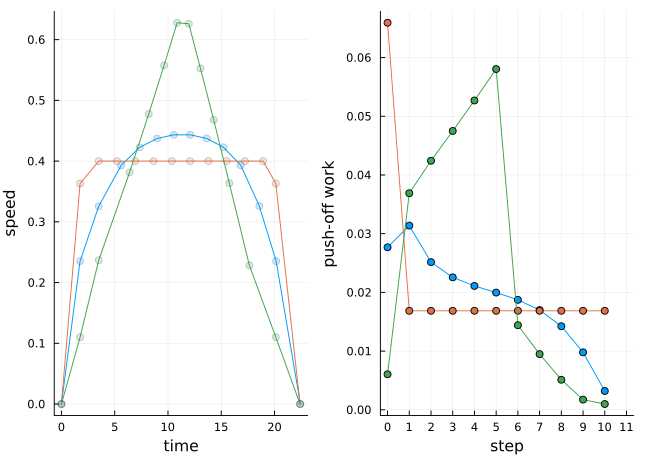

In [2]:
## Triangle walk, based on min var walk
wstar4s = findgait(WalkRW2l(α=0.35,safety=true), target=:speed=>0.5, varying=:P)
wstar4n = findgait(WalkRW2l(α=0.35, safety=true), target=:speed=>0.4, varying=:P)
nsteps = 10
ctime = 0.0195
tchange = 1.75
nominalmsr=optwalktime(wstar4n, nsteps, ctime = ctime, boundarywork=true) # to compare with our usual solution
minvarmsr=optwalkvar(wstar4n, nsteps, boundarywork=true)
A = 1.9*wstar4s.vm/(nsteps*onestep(wstar4s).tf)
v0 = 0.11#0.8*A*tchange#0.12
mintrimsr=optwalktriangle(wstar4n, nsteps, A = A, boundarywork=false,boundaryvels=(v0,v0))
p = plot(layout=(1,2))
plotvees!(p[1],nominalmsr, tchange=tchange, rampuporder=1, usespline = false, markershape=:circle,speedtype=:shortwalks)
plotvees!(p[1],minvarmsr, tchange=tchange, rampuporder=1, usespline = false,markershape=:circle, speedtype=:shortwalks)
plotvees!(p[1],mintrimsr, tchange=tchange, rampuporder=1, usespline = false,markershape=:circle, speedtype=:shortwalks, seriescolor=:auto)
plot!(p[2],[0:nsteps+1], [1/2*nominalmsr.vm0^2; nominalmsr.steps.Pwork; NaN],markershape=:circle,seriescolor=:auto)
plot!(p[2],[0:nsteps+1], [1/2*minvarmsr.vm0^2; minvarmsr.steps.Pwork; NaN],markershape=:circle,xticks=0:nsteps+1)
plot!(p[2],[0:nsteps+1], [1/2*mintrimsr.vm0^2; mintrimsr.steps.Pwork; NaN],markershape=:circle,xticks=0:nsteps+1,seriescolor=:auto)
plot!(p[2],xlabel="step", ylabel="push-off work", legend=false)
energytimework = 1/2*nominalmsr.vm0^2 + sum(nominalmsr.steps.Pwork)
mincotwork = 1/2*minvarmsr.vm0^2 + sum(minvarmsr.steps.Pwork)
trianglework = (1/2*mintrimsr.vm0^2 + sum(mintrimsr.steps.Pwork))/(1/2*nominalmsr.vm0^2 + sum(nominalmsr.steps.Pwork))
Plots.display(p)

Quantify the three predictions. The energy cost for each walk consists
of the positive work for gait initiation plus the positive push-off work
for all steps. Negative work is ignored, because equal magnitudes of
positive and negative work are performed for this task. If there are
constant efficiencies for muscles to perform positive and negative work,
the physiological cost of negative work is proportional to positive
work. This affects the total metabolic cost, but does not affect the
optimal solutions.

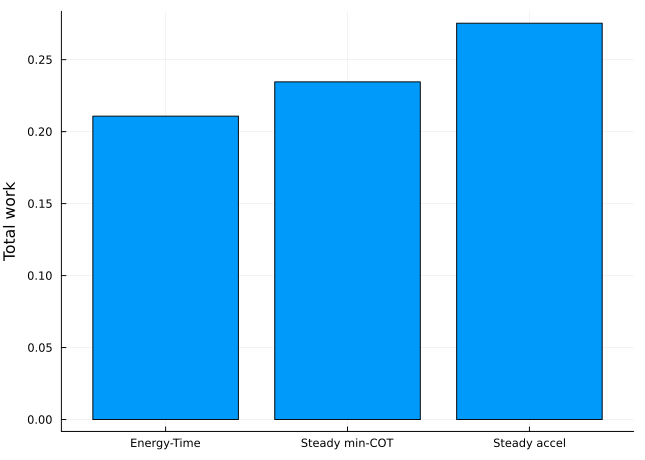

In [3]:
using Markdown
 
threecosts = [1/2*nominalmsr.vm0^2 + sum(nominalmsr.steps.Pwork), 1/2*minvarmsr.vm0^2 + sum(minvarmsr.steps.Pwork), 1/2*mintrimsr.vm0^2 + sum(mintrimsr.steps.Pwork)]
bar(threecosts,xticks=((1,2,3),("Energy-Time", "Steady min-COT", "Steady accel")),legend=false,ylabel="Total work")

In [4]:
using Markdown
Markdown.parse("""
The energy-time work is $(threecosts[1]). 
The min-COT work is $(threecosts[2]).
The const accel work is $(threecosts[3]).
""")

# Jupyter notebook

This code is also available in a [Jupyter notebook](shortwalks.ipynb)
and [plain Julia](shortwalks.jl) text file.